In [1]:
#Matteo Pastorino Ghezzi
#Riccardo Caprile
#Andrea Valli
#Filippo Montanaro

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt

## Instructions on using Keras

Models in Keras are defined as a sequence of layers.

We create a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) object which holds multiple layers executed one by one, and add layers to the object until we have formed the architecture.

To create the first layer, you need to know the right number of input features. You can specify this by using the `input_dim` argument. 

The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity
 - whether or not to add regularization
 
Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The activation functions are used after each dense layer. You can choose the activation functions for hidden layers yourself, a common choice being the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation. But for the last layer, the activation must reflect the range of the outputs.

Since we will work with binary classification problem, the output should be between 0 and 1, which is then easy to map to any given class. To ensure this we can use the [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) activation.


After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to how the model will be optimized:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with some learning rate (instructions on how to choose it follow).
 - The `loss` function. For binary classification you can use the [cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss.
 - A list of `metrics`: common error functions which you want keras to report at each training epoch.
 
Then you may actually train the model by calling **fit**. The fit function takes as input the training data, and some more parameters related to the training process:
 - `epochs` : the number of epochs to train for
 - `batch_size` : the size of mini-batches. A high batch-size will speed up computations but may make training unstable.
 
Other useful functions are `model.predict` which runs the model's forward pass to predict on new samples, and `model.evaluate` which is similar to `predict` but instead of giving predictions as output, it simply computes some metrics.

In [2]:
def generate_2d_cls_data(n, sigma_noise):
    n_cls = n // 2
    
    theta = np.random.randn(n_cls) * 2 * np.pi
    cls1 = np.stack([np.cos(theta) * 2, np.sin(theta) * 2], axis=1)
    cls2 = np.random.randn(n_cls, 2) * 0.5

    cls1 += np.random.randn(cls1.shape[0], 2) * sigma_noise * 3
    cls2 += np.random.randn(cls2.shape[0], 2) * sigma_noise
    
    X = np.concatenate([cls1, cls2], axis=0)
    y = np.concatenate([np.zeros(n_cls), np.ones(n_cls)], axis=0)
    
    return X, y

In [3]:
def separatingFLR(data, labels, predictions, model):
    fig, ax = plt.subplots()
    
    num_grid_points = 100
    xi = np.linspace(data[:, 0].min(), data[:, 0].max(), num_grid_points)
    yi = np.linspace(data[:, 1].min(), data[:, 1].max(), num_grid_points)
    gdata = np.stack([xi, yi], 1)
    X, Y = np.meshgrid(xi,yi)
    pred_grid = model.predict(
        np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    ).reshape(num_grid_points, num_grid_points)
    
    ax.contour(xi, yi, pred_grid, 15, linewidths=2, colors='k', levels=[0.5])
    # plot data points.
    ax.scatter(data[:,0], data[:,1], c=labels.ravel(), marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(data[:,0].min(), data[:,0].max())
    ax.set_ylim(data[:,1].min(), data[:,1].max())
    return fig, ax

In [4]:
def calc_err(predicted, observed):
    predicted = predicted.ravel()
    observed = observed.ravel()
    threshold_preds = predicted.copy()
    threshold_preds[predicted < 0.5] = 0
    threshold_preds[predicted >= 0.5] = 1
    return np.mean(threshold_preds != observed)

## Exploring Different Architectures

Using a simple binary classification dataset you will build a keras model with Dense layers, and the RELU activation function.

You will explore different architectures to try and see when the NN overfits or underfits the data.

In particular, you should try the following:
 1. A NN with a single hidden layer with few (e.g. 3, 4) neurons
 2. A NN with a single hidden layer with many (e.g. 100) neurons
 3. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30).
 
Train the neural network using the SGD algorithm with a learning rate of 0.05 (you may explore different values) for 500 epochs (or less if time doesn't permit).

For each setting you try, plot the training and validation errors as a function of the epochs, and plot the separating function (use the `separatingFLR` function).

For each setting comment on whether the NN is overfitting or not. Further comment on which model you believe is better, and why (e.g. computational or accuracy considerations).

We provide some skeleton code to train and evaluate a model, you'll have to fill it in, and do the same thing multiple times for different models.

#### Generating the train and test sets

Note that with neural nets, the labels for binary classification should be 0 and +1.

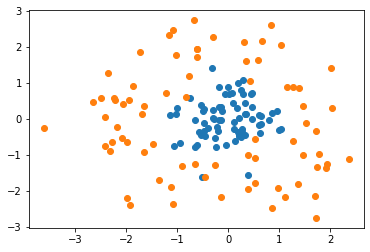

In [5]:
np.random.seed(34)
Xtr, Ytr = generate_2d_cls_data(150, 0.2)
Xte, Yte = generate_2d_cls_data(100, 0.2)

fig, ax = plt.subplots()
ax.scatter(Xtr[Ytr == 1,0], Xtr[Ytr == 1, 1])
ax.scatter(Xtr[Ytr == 0,0], Xtr[Ytr == 0, 1])

#### Build a model and train it

### **1. A NN with a single hidden layer with few (e.g. 3, 4) neurons**

In [6]:
# Build your first model by creating a Sequential object and then adding 3 Dense layers:
model = Sequential()
model.add(Dense(3, input_dim= (Xtr.shape[1]), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=500,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds,Ytr)
test_err = calc_err(test_preds,Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/500
12/12 [==============================] - 1s 21ms/step - loss: 0.6928 - accuracy: 0.5250 - val_loss: 0.7275 - val_accuracy: 0.0333
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.6083 - val_loss: 0.7619 - val_accuracy: 0.0000e+00
Epoch 3/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6250 - val_loss: 0.7926 - val_accuracy: 0.0000e+00
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6250 - val_loss: 0.8179 - val_accuracy: 0.0000e+00
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6250 - val_loss: 0.8409 - val_accuracy: 0.0000e+00
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.6480 - accuracy: 0.6250 - val_loss: 0.8590 - val_accuracy: 0.0000e+00
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 0.6430 - accuracy: 0.6250 - val_loss: 0.8748 - val_accuracy:

#### Plot the results from the model

In [7]:
# With this function you can plot the history of the model training produced by the fit function
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

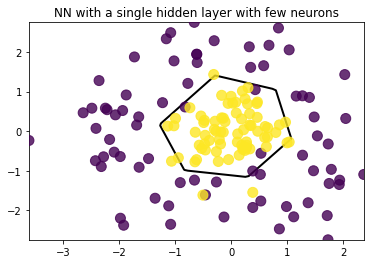

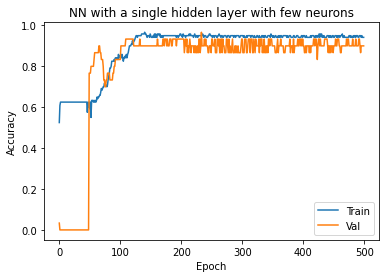

In [8]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("NN with a single hidden layer with few neurons");
fig, ax = plot_history(history)
ax.set_title("NN with a single hidden layer with few neurons");

### **Comment:** This is the first NN we compute: for all the NNs present, the number of epochs is 500 as Colab is fast in computing all of them. In this specific model the error are acceptable but we can see from the accuracy plot that the model is affected by overfitting

## **2. A NN with a single hidden layer with many (e.g. 100) neurons**

In [9]:
model = Sequential()
model.add(Dense(100, input_dim= (Xtr.shape[1]), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=500,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds,Ytr)
test_err = calc_err(test_preds,Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/500
12/12 [==============================] - 1s 18ms/step - loss: 0.7162 - accuracy: 0.4500 - val_loss: 0.7087 - val_accuracy: 0.2333
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.4333 - val_loss: 0.7363 - val_accuracy: 0.0000e+00
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.5500 - val_loss: 0.7610 - val_accuracy: 0.0000e+00
Epoch 4/500
12/12 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6083 - val_loss: 0.7829 - val_accuracy: 0.0000e+00
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6250 - val_loss: 0.8022 - val_accuracy: 0.0000e+00
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6250 - val_loss: 0.8192 - val_accuracy: 0.0000e+00
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.6250 - val_loss: 0.8341 - val_accuracy:

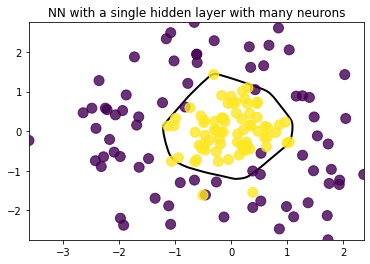

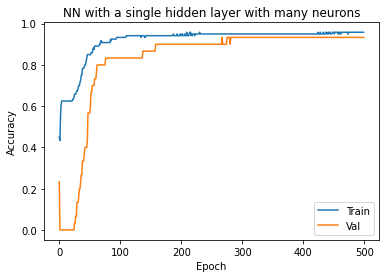

In [10]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("NN with a single hidden layer with many neurons");
fig, ax = plot_history(history)
ax.set_title("NN with a single hidden layer with many neurons");

### **Comment:** As suggested by the notebook, we are now changing the learning rate to 0.01. The error is slighty higher than the previous model but the accuracy on the validation set is more stable.

## **3. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30)**

In [11]:
units = 18

model = Sequential()
model.add(Dense(units, input_dim= (Xtr.shape[1]), activation='relu'))  # input layer
model.add(Dense(units, input_dim= (Xtr.shape[1]), activation='relu'))
model.add(Dense(units, input_dim= (Xtr.shape[1]), activation='relu'))
model.add(Dense(units, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))  # This is the last layer (i.e output layer), it should have 1 neuron and the sigmoid activation

# You can check that your model has the correct number of layers:
model.layers

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=150,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds,Ytr)
test_err = calc_err(test_preds,Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/150
12/12 [==============================] - 1s 19ms/step - loss: 0.5807 - accuracy: 0.6250 - val_loss: 0.8501 - val_accuracy: 0.0000e+00
Epoch 2/150
12/12 [==============================] - 0s 4ms/step - loss: 0.5417 - accuracy: 0.6250 - val_loss: 0.8551 - val_accuracy: 0.0000e+00
Epoch 3/150
12/12 [==============================] - 0s 6ms/step - loss: 0.5078 - accuracy: 0.6667 - val_loss: 0.8541 - val_accuracy: 0.0667
Epoch 4/150
12/12 [==============================] - 0s 4ms/step - loss: 0.4834 - accuracy: 0.6917 - val_loss: 0.8170 - val_accuracy: 0.2667
Epoch 5/150
12/12 [==============================] - 0s 6ms/step - loss: 0.4513 - accuracy: 0.8000 - val_loss: 0.8259 - val_accuracy: 0.3333
Epoch 6/150
12/12 [==============================] - 0s 5ms/step - loss: 0.4270 - accuracy: 0.8250 - val_loss: 0.7894 - val_accuracy: 0.4000
Epoch 7/150
12/12 [==============================] - 0s 6ms/step - loss: 0.4024 - accuracy: 0.8583 - val_loss: 0.6898 - val_accuracy: 0.8000
Epoc

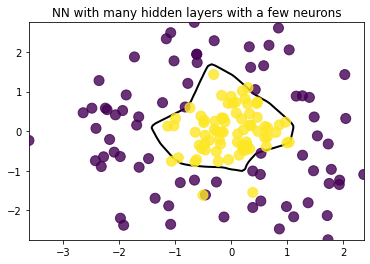

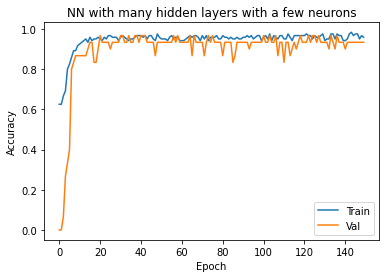

In [12]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("NN with many hidden layers with a few neurons");
fig, ax = plot_history(history)
ax.set_title("NN with many hidden layers with a few neurons");

### **Comment:** In here, we set the number of neurons/units to 18 and the learning rate to 0.05 again; since we have many layers, the computational time is higher than before and so we decided to lower the numer of epochs since, in the previous models, after 150 iterations, the accuracy didn't change. The training error is lower but the test one is higher than the previous models. Becuase we added many layers, the model is overfitting: in many application, one hidden layer is enough (*as stated by Aurélien Géron in Hands-On Machine Learing with Scikit-Learn, Keras, and TensorFlow (2nd edition) "Number of Hidden Layers" paragraph, pag.323*)

### **Final comment:** From what we've seen the best model is the second one (single hidden layer with many neurons) as it's the only one that doesn't overfit and the errors, along with the accuracy, are good

## Train a Neural Network on MNIST!

We can finally switch to a real dataset now.

First we will load the MNIST dataset and plot it to see how it really looks like.

Then we will use the notions learned in the first part to train a model which can distinguish two digits in the MNIST data.

As a bonus, some of you may want to look into multi-class classification and train a model on the whole MNIST dataset!

## Load Data

In [13]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


Take a look at the data, try plotting the images.

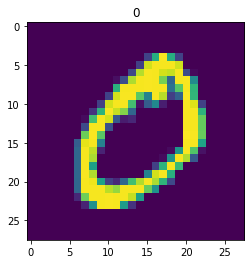

In [14]:
fig, ax = plt.subplots()
ax.imshow(x_train[1])
ax.set_title(y_train[1]);

In [15]:
# Have a look at the targets. This is a multiclass problem!
print(y_train[0], y_train[1])

5 0


#### Bring the data into shape

1. Choose the digits we want to classify (variables `num_1` and `num_2`)
2. Then we restrict training and test sets to only use those numbers
3. We reshape the images from 28*28 to a single 784-dimensional vector
4. Finally we modify the labels to their appropriate range (0 and +1)

In [16]:
num_1 = 1
num_2 = 7

# Here we take only two digits from MNIST. 
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

# Reshape the data correctly
Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

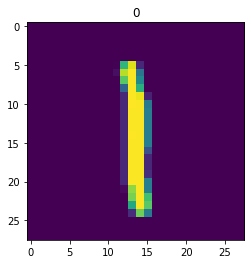

In [17]:
fig, ax = plt.subplots()
ax.imshow(Xtr[3].reshape(28, 28))
ax.set_title(Ytr[3]);

#### Define The Keras Model

In [18]:
model = Sequential()
model.add(Dense(4,input_dim = Xtr.shape[1], activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

#### Compile The Keras Model

Here we will use the Adam optimizer instead. It tends to work better than SGD with high dimensional data (such as our MNIST images).

In [19]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',#optimizer=tf.keras.optimizers.Adam( learning_rate= 0.1),
    metrics=['accuracy'],)

#### Fit the model

In [20]:
# fit the keras model on the dataset
history = model.fit(Xtr, Ytr, 
                    epochs=100, 
                    batch_size=10,
                    validation_split=0.2)

Epoch 1/100
1041/1041 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.9544 - val_loss: 0.0436 - val_accuracy: 0.9904
Epoch 2/100
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0474 - accuracy: 0.9869 - val_loss: 0.0530 - val_accuracy: 0.9823
Epoch 3/100
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0454 - accuracy: 0.9912 - val_loss: 0.0196 - val_accuracy: 0.9904
Epoch 4/100
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0417 - val_accuracy: 0.9908
Epoch 5/100
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0319 - accuracy: 0.9943 - val_loss: 0.0272 - val_accuracy: 0.9939
Epoch 6/100
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0169 - accuracy: 0.9954 - val_loss: 0.0362 - val_accuracy: 0.9950
Epoch 7/100
1041/1041 [==============================] - 2s 2ms/step - loss: 0.0171 - accuracy: 0.9958 - val_loss: 0.0193 - val_ac

In [21]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds,Ytr)
test_err = calc_err(test_preds,Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Training error: 0.12%, Test error: 0.51%


In [22]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))
# Yes, the model is consistent

68/68 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9949
Test accuracy: 99.49%


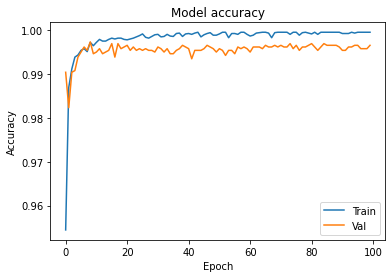

In [23]:
# Plot training history
fig, ax = plot_history(history)